# Breaking the Vigenère cipher

The Vigenère cipher is as simple as they come. The standard attack is not much more complicated, but when I first came across it, it seemed a little magical. Armed with some rudimentary probability theory we can quickly dispel this magic, and along the way we'll get our hands dirty with Python and encrypt a Reddit post or two.

Before we begin, let's declare all the imports we'll need throughout this notebook:

In [1]:
import requests
import time

import random
random.seed(1)

import matplotlib.pyplot as plt
%matplotlib inline

With that out of the way, we'll define the Vigenère cipher and its predecessor, the substitution cipher. Onwards!

## The substitution and Vigenère ciphers

We can implement a simple substitution cipher by XORing every byte of some message $m=[m_1,m_2,\ldots]$ with a fixed key $k$ to get ciphertext $c=[c_1, c_2, \ldots]$. For example, with $k=01011010$ and $m=\text{"foobar"}$:

\begin{align*}
m_1 \oplus k &= c_1 &                              & & 01100110 \oplus 01011010 &= 00111100\\
m_2 \oplus k &= c_2 & \text{and encoded in ASCII,} & & 01101111 \oplus 01011010 &= 00110101\\
m_3 \oplus k &= c_3 &                              & & 01101111 \oplus 01011010 &= 00110101\\
& \ldots & & & & \ldots
\end{align*}

Writing this out by hand isn't much fun; let's ask a computer to help.

In [2]:
def substitution(key, plaintext):
    return [key ^ m for m in plaintext]

In [3]:
key = 0b01011010
ciphertext = substitution(key, str.encode('foobar', 'ascii'))
'Ciphertext c = ' + ', '.join('{:08b}'.format(m) for m in ciphertext)

'Ciphertext c = 00111100, 00110101, 00110101, 00111000, 00111011, 00101000'

If we wish to decrypt our message, we can rerun the exact same steps only with the ciphertext in place of the message (ie. the substitution cipher is its own inverse).

In [4]:
''.join(chr(c) for c in substitution(key, ciphertext))

'foobar'

If a ne'er-do-well intercepts our message, however, they won't have a hard time breaking our substitution cipher. They only have to XOR the ciphertext against each of the $2^8=256$ different possible keys and look at those which have a letter frequency that most closely matches English text. (Try this yourself with a slightly longer message! If you're in need of a table of letter frequencies, Peter Norvig has [you covered](http://norvig.com/mayzner.html).)

We can complicate an eavesdropper's life by using more than one byte as a key and XORing our message against these bytes in a loop. For example, we would encrypt the same message $m=\text{"foobar"}$ with a key $k=[k_1, k_2]=[01011010, 01111100]$ of length two as follows:

\begin{align*}
m_1 \oplus k_1 &= c_1 &                              & & 01100110 \oplus 01011010 &= 00111100\\
m_2 \oplus k_2 &= c_2 & \text{and encoded in ASCII,} & & 01101111 \oplus 01111100 &= 00010011\\
m_3 \oplus k_1 &= c_3 &                              & & 01101111 \oplus 01011010 &= 00110101\\
m_4 \oplus k_2 &= c_4 &                              & & 01100010 \oplus 01111100 &= 00011110\\
& \ldots & & & & \ldots
\end{align*}

This is the Vigenère cipher. Once again, we can use a computer do our encrypting for us.

In [5]:
def vigenère(key, plaintext):
    return [key[idx % len(key)] ^ m for idx, m in enumerate(plaintext)]

In [6]:
key = (0b01011010, 0b01111100)
ciphertext = vigenère(key, str.encode('foobar', 'ascii'))
'Ciphertext c = ' + ', '.join('{:08b}'.format(c) for c in ciphertext)

'Ciphertext c = 00111100, 00010011, 00110101, 00011110, 00111011, 00001110'

As with the substitution cipher, the Vigenère cipher is its own inverse.

In [7]:
''.join(chr(c) for c in vigenère(key, ciphertext))

'foobar'

If an eavesdropper intercepts our encrypted message and they know the length of the key $L$, then they can work out the key by treating the encrypted message as $L$ different messages, each encrypted by a substitution cipher, which they can individually decrypt using the letter frequency attack. For our example above, an attacker would break apart the encrypted message into the bytes at even positions and the bytes at odd positions.

In [8]:
'Bytes at even positions = ' + ', '.join('{:08b}'.format(c) for c in ciphertext[::2])

'Bytes at even positions = 00111100, 00110101, 00111011'

In [9]:
'Bytes at odd positions = ' + ', '.join('{:08b}'.format(c) for c in ciphertext[1::2])

'Bytes at odd positions = 00010011, 00011110, 00001110'

There's no reason for us to make the key length public though, so how could an attacker figure it out?

The answer is far from obvious, and we'll take our time to explore it. The attack begins by guessing lots of different key lengths, and for each guess $l$, the attacker calculates the average [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance) between bytes $l$ positions apart. The key length for which the average hamming distance is the smallest is likely to be the key length used to encrypt the message.

At first blush, this seems unintuitive. For example, if our messages are uniform random samples of bytes, won't the result of XORing the messages against different bytes also have (a) the same uniform distribution and (b) be independent of each other? If this is the case then won't the expected hamming distance be the same for all key lengths?

It's time to get empirical.

## Simulating key length guessing with uniformly random messages

We'll need a few tools to help us along.

In [10]:
def hamming_dist(x, y):
    return bin(x ^ y).count('1')


def ave_hamming_dist(key_length, msg):
    "For msg, compute the average hamming distance between pairs of bytes key_length apart."
    num_comparisons = len(msg) // (2 * key_length)
    dist_sum = 0
    for offset in range(key_length):
        for i in range(num_comparisons):
            dist_sum += hamming_dist(msg[offset + 2*i*key_length],
                                     msg[offset + (2*i + 1)*key_length])
    return dist_sum / (num_comparisons * key_length)


def uniform_random_plaintext(length):
    "Generate a list of length uniformly distributed random bytes"
    return [random.randrange(0, 256) for i in range(length)]

We're now ready to simulate our key length guessing attack 1000 times. For each run, we will encrypt a random message with the same length two $(L=2)$ key and measure the average hamming distance for bytes both one and two positions apart.

In [11]:
RANDOM_MSG_LENGTH = int(1e4)
SAMPLE_SIZE = int(1e3)
ave_hamming_dists = []
for _ in range(SAMPLE_SIZE):
    ciphertext = vigenère(key, uniform_random_plaintext(RANDOM_MSG_LENGTH))
    ave_hamming_dists.append((ave_hamming_dist(1, ciphertext),
                              ave_hamming_dist(2, ciphertext)))

For the attack to be successful, we would expect to see that the average hamming distance for bytes two positions apart is consistently smaller than the average hamming distance for adjacent bytes. Let's eyeball the first ten runs.

In [12]:
ave_hamming_dists[:10]

[(3.984, 3.9852),
 (4.0, 3.9928),
 (3.974, 4.016),
 (4.022, 3.9988),
 (3.9736, 4.012),
 (3.9682, 3.9874),
 (3.9712, 4.0),
 (4.0448, 3.9964),
 (4.0338, 4.0302),
 (4.0064, 3.994)]

All of the distances are close to 4, which is what we'd expect from i.i.d. uniformly distributed random bytes. Of the ten runs, guessing $l=1$ results in a smaller average hamming distance on five runs, which doesn't look promising for our hypothetical attacker.

We can get a more complete picture by plotting the histogram of difference between the hamming distances for each run.

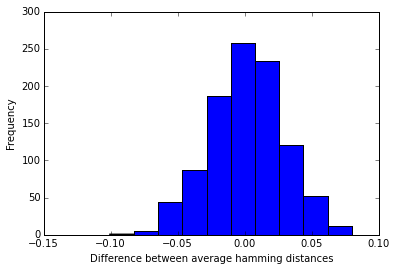

In [13]:
plt.hist([dist1 - dist2 for dist1, dist2 in ave_hamming_dists])
plt.xlabel('Difference between average hamming distances')
plt.ylabel('Frequency')
plt.show()

This plot is centred at and symmetric around zero, which aligns with what we hypothesised and spells trouble for our attacker: considering the average hamming distance between bytes a fixed width apart doesn't seem to provide any clues as to what the original key length $L$ is.

What gives?

Well, if we think back to the substitution cipher, one easy attack involved trying to match observed letter frequencies with some benchmark. This attack is clearly predicated on the distribution of the the bytes in the message *not* being uniform, so maybe a similar precondition is required here?

Rather than test this hypothesis against a second more or less arbitrary distribution, we'll source some content generated by people rather than machines; after all, this is what cryptography was originally invented for. Reddit is a good source of short messages that has an easy to use API, so we'll start there.

## Simulating key length guessing with Reddit posts

We'll begin with code that requests for the most recent posts from the crypto subreddit. Note that if you're running this code at home, you'll likely receive different posts and hence will get slightly different results.

In [14]:
def request_reddit_posts(num_posts, after=None, count=None):
    """Fetch posts from the Crypto subreddit. Note that each response will
    contain at most 100 posts, see https://github.com/reddit/reddit/wiki/API."""
    params = {'limit': num_posts}
    headers = {'user-agent': 'python:research:v1 (by andres-s)'}
    if after:
        params['after'] = after
    if count and count > 0:
        params['count'] = count
    resp = requests.get('https://www.reddit.com/r/crypto/new.json',
                        headers=headers, params=params)
    
    resp_data = resp.json()['data']
    posts = (post['data']['title'] + '\n' + post['data']['selftext']
                for post in resp_data['children'])
    return (resp_data['after'], posts)


def reddit_posts(n):
    """Generator for reddit posts. The docs mention rate limiting
    response headers, but I didn't observe any, so I've just used a timer
    to keep to within the mandated 30 requests/minute limit."""
    MIN_REQ_DIFF = 2  # in seconds
    time_last_request = None
    after = None
    count = 0
    while count < n:
        req_diff = time.perf_counter() - time_last_request if time_last_request else None
        if req_diff and req_diff < MIN_REQ_DIFF:
            time.sleep(MIN_REQ_DIFF - req_diff)

        after, posts = request_reddit_posts(min(n - count, 100),
                                            after=after, count=count)
        time_last_request = time.perf_counter()
        for post in posts:
            yield post
            count += 1
            # The following check defends against us receiving more posts
            # than we requested.
            if count >= n:
                break

Let's take a quick look at what's at the top of the subreddit.

In [15]:
for post in reddit_posts(3):
    print(post)

DSA 1024 with known bits of k (every 15th bit), is this broken?
There was an OTR implementation that used a bad big num library that used 15 bit limbs that only filled the lower 14 bits/limb with random. So both primes (besides the larger prime's lower ~160 bits because Q divides P-1), private key, and k had every 15th bit set to zero. Signatures can be requested but not a lot (max million-ish [probably takes days]) as it's written in JS and thus slow.

From what I know about DSA, it's "broken" but how broken is it or at all? From what I know about lattice attacks, for those to work you need the known bits to be contiguous.
NSA advisory sparks concern of secret advance ushering in cryptoapocalypse

My question on SO: File encryption using per-user-encrypted shared key



Neat! We are now in a position to repeat our experiment with Reddit posts instead of computer-generated messages.

In [16]:
ave_hamming_dists = []
for post in reddit_posts(SAMPLE_SIZE):
    ciphertext = vigenère(key, str.encode(post, encoding="utf-8"))
    ave_hamming_dists.append((ave_hamming_dist(1, ciphertext),
                              ave_hamming_dist(2, ciphertext)))

ave_hamming_dists[:10]

[(3.749206349206349, 2.8853503184713376),
 (4.0, 2.888888888888889),
 (4.0, 3.176470588235294),
 (3.9411764705882355, 2.7542372881355934),
 (3.751937984496124, 2.6875),
 (3.7857142857142856, 2.9285714285714284),
 (3.5434782608695654, 3.282608695652174),
 (3.6341463414634148, 2.823529411764706),
 (3.5517241379310347, 2.7325581395348837),
 (3.945945945945946, 3.0555555555555554)]

This time we see a marked difference between the two sets of hamming distances, with a correctly guessed key length resulting in consistently smaller averages.

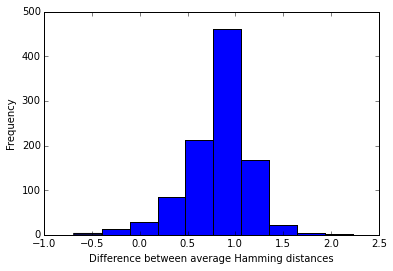

In [17]:
plt.hist([dist1 - dist2 for dist1, dist2 in ave_hamming_dists])
plt.xlabel('Difference between average Hamming distances')
plt.ylabel('Frequency')
plt.show()

From the histogram we see that the average difference between the average Hamming distances (how's that for a mouthful!) is about 0.9 and almost always positive. It's clear that this attack almost always succeeds in choosing the correct key length.

This is a great result for our nefarious message interceptor, but it's still not clear *why* this attack works. What is it about Reddit posts that makes them easier to decrypt than our randomly generated messages? Can we depend on this attack working for other human-generated content? To provide precise answers to these questions, we'll employ some elementary probability theory.

## Modelling messages

We'll model the message that we'd like to encrypt as a succession of random bytes, each identically distributed and independent of all the others. We'll focus our attention on two of these bytes, $X=(X_1, \ldots, X_8)$ and $Y=(Y_1, \ldots, Y_8)$. Each $X_i$ and $Y_i$ is a random bit and will take the value zero with probability $P(X_i=0)$ and $P(Y_i=0)$ respectively, and take the value one with probability $P(X_i=1)$ and $P(Y_i=1)$. The Vigenère encryption scheme will encrypt the two bytes by XORing them with the fixed bytes $a=(a_1, \ldots, a_8)$ and $b=(b_1, \ldots, b_8)$ respectively. When we take the average Hamming distance of bytes a fixed number of positions apart we are effectively estimating the expected value of the Hamming distance $h(a\oplus X, b\oplus Y)$, or

$$
E[h(a\oplus X, b\oplus Y)].
$$

When our guess of the key length matches the actual key length, then $a=b$ and we are evaluating

$$
E[h(a\oplus X, a\oplus Y)].
$$

Thus to prove that this method of deducing the key length is effective, we would like to show that

$$
E[h(a\oplus X, a\oplus Y)] \leq E[h(a\oplus X, b\oplus Y)].
$$

for all $b$.

As it turns out, we can get precise results without much work. We have

\begin{align*}
E[h(a\oplus X, b\oplus Y)] 
&= E\left[\sum_{i=1}^8(a_i\oplus X_i)\oplus(b_i\oplus Y_i)\right]\\
&=\sum_{i=1}^8E\left[(a_i\oplus X_i)\oplus(b_i\oplus Y_i)\right]\\
&=\sum_{i=1}^8E\left[(a_i\oplus b_i)\oplus(X_i\oplus Y_i)\right].
\end{align*}

The expectation of the Bernoulli random variable $(a_i\oplus b_i)\oplus(X_i\oplus Y_i)$ is just $P((a_i\oplus b_i)\oplus(X_i\oplus Y_i)=1)$. We now need to consider two cases: $a_i=b_i$ and $a_i=1-b_i$. When $a_i=b_i$,

\begin{align*}
P\left((a_i\oplus b_i)\oplus(X_i\oplus Y_i)=1\right) &= P(X_i\oplus Y_i=1)\\
&= P(X_i=1\wedge Y_i=0) + P(X_i=0\wedge Y_i=1)\\
&= P(X_i=1)P(Y_i=0) + P(X_i=0)P(Y_i=1)\\
&= 2P(X_i=1)P(X_i=0),
\end{align*}

where we have used the fact that $X$ and $Y$ are independent and identically distributed to derive the last two expressions. Similarly, when $a_i=1-b_i$,

\begin{align*}
P\left((a_i\oplus b_i)\oplus(X_i\oplus Y_i)=1\right) &= P(X_i\oplus Y_i=0)\\
&= P(X_i=1\wedge Y_i=1) + P(X_i=0\wedge Y_i=0)\\
&= P(X_i=1)P(Y_i=1) + P(X_i=0)P(Y_i=0)\\
&= P(X_i=1)^2 + P(X_i=0)^2.
\end{align*}

Putting the two cases together, we have

\begin{align*}
P\left((a_i\oplus b_i)\oplus(X_i\oplus Y_i)=1\right)
=&\sum_{i=1}^8(1-a_i\oplus b_i)(2P(X_i=1)P(X_i=0))\\
&\quad\ + (a_i\oplus b_i)(P(X_i=1)^2+P(X_i=0)^2)\\
=&\sum_{i=1}^8 2P(X_i=1)P(X_i=0) + (a_i\oplus b_i)\left(P(X_i=1)-P(X_i=0)\right)^2.
\end{align*}

When $a=b$, all the $a_i\oplus b_i$ are zero, hence

\begin{align*}
E[h(a\oplus X, b\oplus Y)] - E[h(a\oplus X, a\oplus Y)]
&= \sum_{i=1}^8 (a_i\oplus b_i)\left(P(X_i=1)-P(X_i=0)\right)^2\\
&= \sum_{i=1}^8 (a_i\oplus b_i)\left(2P(X_i=1)-1\right)^2.
\end{align*}

As this value is always nonnegative, we have shown that

$$
E[h(a\oplus X, a\oplus Y)] \leq E[h(a\oplus X, b\oplus Y)].
$$

Moreover, we now have a precise condition under which equality holds: $E[h(a\oplus X, a\oplus Y)] = E[h(a\oplus X, b\oplus Y)]$ if and only if for each $i$, either $a_i\oplus b_i=0$ or $P(X_i=1)=1/2$.

For our first simulation, $P(X_i=1)=1/2$ for all $i$, which explains why we were not able to guess the key length by comparing Hamming distances.

## Further questions

While our model's simplicity let us quickly arrive at an explanation as to why the attack on the Vigenère key length works on Reddit posts but not uniformly random messages, it may be too simple to provide a robust description of English writing. For example, every byte of the message is modelled as having the same probability distribution, but we would expect upper case letters to have a much higher probability of appearing as the first character of a message than at a later position. Similarly we would expect that a white space character would be much less likely to appear as the first character of a message. The model also assumes that probability distributions of each byte are all independent of each other, where we would expect that the character 'h' would be more likely to appear after 't' than not, for example. In light of these observations, can we adapt our proof to make use of more general hypotheses but arrive at similar results? 

We have also not addressed how reliable the Vigenère key length attack is; after all, even for the some of the Reddit posts, the key length attack produced the wrong answer. Formally, given a message of some length $n$ encrypted with a key of length $L$, what's the probability that the key length attack will guess the correct key length? Care would need to be taken when answering this question, because a real attacker would try more than two key lengths and would be happy enough trying to solve the substitution cipher for multiple key lengths. 